# This is Lab 6 for IA 340

## This analysis will cover income and population growth from 2005 to 2019 with US Census Data.

### Preface code

In [3]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [4]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

In [5]:
# 1. Drop table if it already exists (optional)
cur.execute("DROP TABLE IF EXISTS name_population;")

# 2. Create the new table
cur.execute("""
CREATE TABLE name_population (
    fips VARCHAR(4),
    name VARCHAR(100),
    year INTEGER,
    pop INTEGER
);
""")

# 3. Insert data from join of population + name
cur.execute("""
INSERT INTO name_population (fips, name, year, pop)
SELECT 
    p.fips,
    n.name,
    p.year,
    p.pop
FROM population p
JOIN name n ON p.fips = n.fips;
""")

# Commit changes
conn.commit()

print("✅ Table 'name_population' created and populated successfully!")

✅ Table 'name_population' created and populated successfully!


In [6]:
sql = """
     select * from name_population
     where fips = '08'
     """

In [7]:
import pandas as pd

co_df = pd.read_sql(sql, con=conn)
co_df.head() #show the top 5 rows

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_11022/2423996691.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  co_df = pd.read_sql(sql, con=conn)


,fips,name,year,pop
0,08,Colorado,2005,4562244
1,08,Colorado,2006,4753377
2,08,Colorado,2007,4861515
3,08,Colorado,2008,4939456
4,08,Colorado,2009,5024748


In [8]:
! pip install jupyter-ai-magics[all] -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.11.10 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.


In [9]:
import warnings
warnings.simplefilter('ignore')

In [10]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [11]:
%load_ext jupyter_ai_magics

In [12]:
%%ai gpt4 -f code
Please create a line chart using {co_df} to show the Year-over-Year population growth 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'fips': ['08']*15,
    'name': ['Colorado']*15,
    'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
    'pop': [4562244, 4753377, 4861515, 4939456, 5024748, 5049071, 5116796, 5187582, 5268367, 5355866, 5456574, 5540545, 5607154, 5695564, 5758736]
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['pop'], marker='o')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Year-over-Year Population Growth in Colorado')
plt.grid()

plt.show()

#### Question 1 - State Population Growth Visualizaton

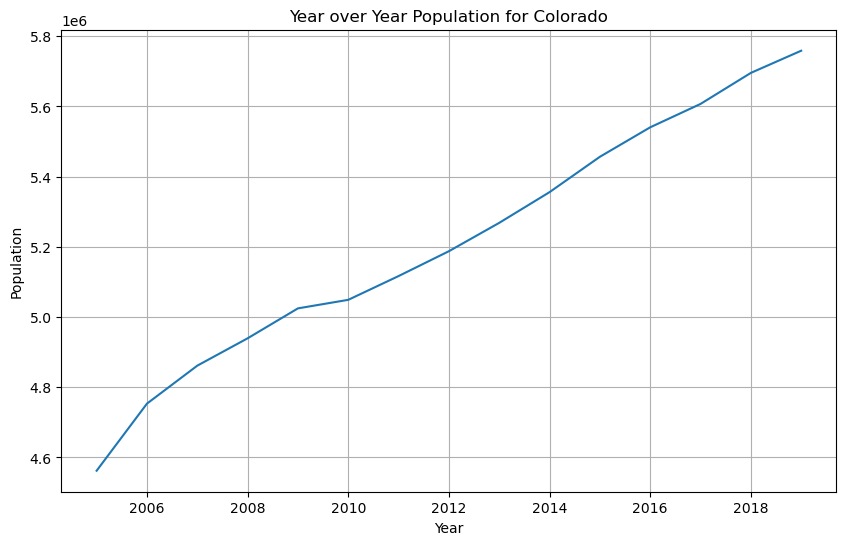

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'fips': ['08']*15,
    'name': ['Colorado']*15,
    'pop': [4562244, 4753377, 4861515, 4939456, 5024748, 5049071, 5116796, 5187582, 5268367, 
            5355866, 5456574, 5540545, 5607154, 5695564, 5758736],
    'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
}

df = pd.DataFrame(data)

plt.figure(figsize=(10,6))
plt.plot(df['year'], df['pop'])
plt.title('Year over Year Population for Colorado')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()

##### From 2005 to 2019, Colorado's population has increased at a stead rate.

### Question 2 - Income and Population Relationship Visualization

In [25]:
query = """
SELECT 
    n.name AS state,
    i.year,
    i.income AS median_household_income,
    p.pop AS population
FROM income AS i
JOIN population AS p
    ON i.fips = p.fips 
    AND i.year = p.year
JOIN name AS n
    ON i.fips = n.fips
WHERE n.name = 'Colorado'
ORDER BY i.year;
"""

df = pd.read_sql_query(query, conn)
display(df.head())


,state,year,median_household_income,population
0,Colorado,2005,50652,4562244
1,Colorado,2006,52015,4753377
2,Colorado,2007,55212,4861515
3,Colorado,2008,56993,4939456
4,Colorado,2009,55430,5024748


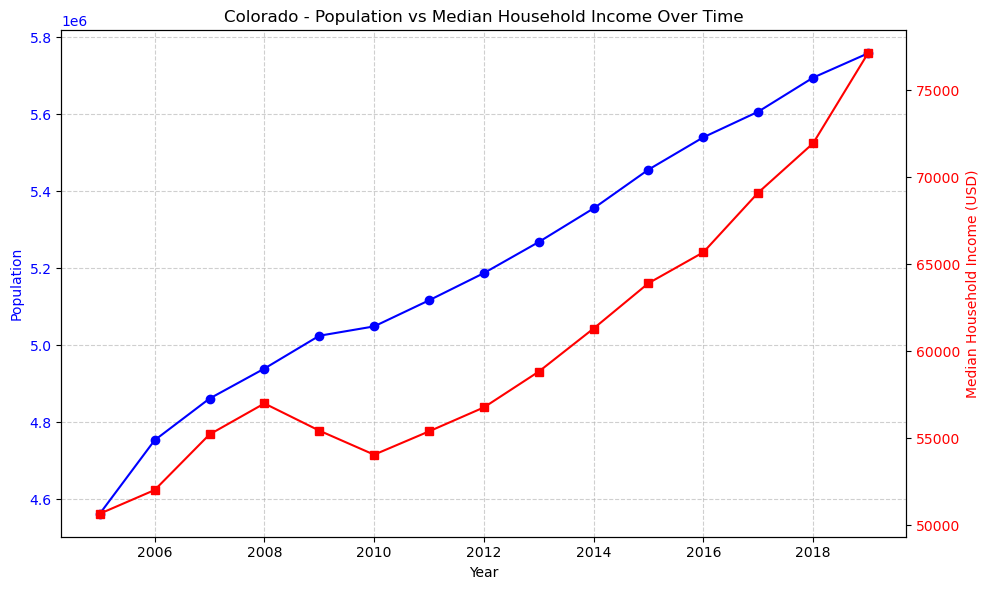

In [28]:
import matplotlib.pyplot as plt

state_name = df['state'].iloc[0]
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left axis: Population (line)
ax1.plot(df['year'], df['population'], color='blue', marker='o', label='Population')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1.grid(True, which='major', linestyle='--', alpha=0.6)

# Right axis: Median Income (line)
ax2 = ax1.twinx()
ax2.plot(df['year'], df['median_household_income'], color='red', marker='s', label='Median Income')
ax2.set_ylabel('Median Household Income (USD)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title
plt.title(f'{state_name} - Population vs Median Household Income Over Time')
fig.tight_layout()
plt.show()


##### Colorado never experienced a drop in population growth during ths period. Median Household Income experienced two years of decline in 2009 and 2010, but otherwise was increasing over this time period.

#### Question 3

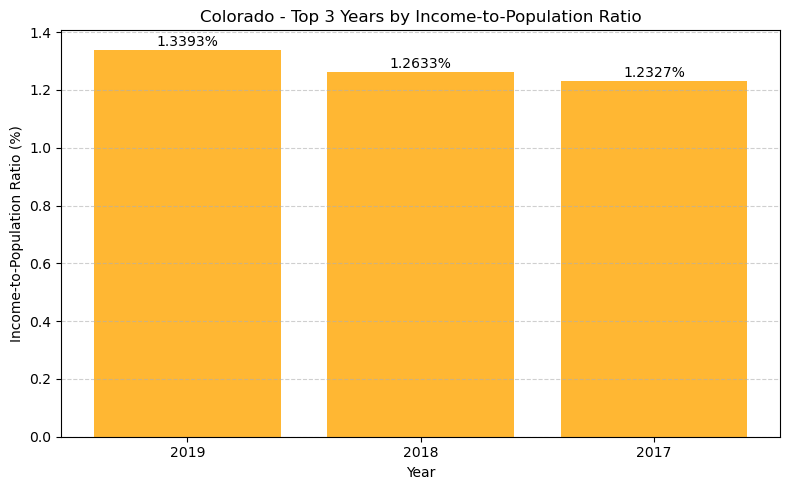

,year,median_household_income,population,ratio_percent
0,2019,77127,5758736,1.339304
1,2018,71953,5695564,1.263317
2,2017,69117,5607154,1.232657


In [35]:
query = """
SELECT 
    n.name AS state,
    i.year,
    i.income AS median_household_income,
    p.pop AS population,
    ROUND((i.income::numeric / p.pop::numeric) * 100, 6) AS ratio_percent
FROM income AS i
JOIN population AS p
    ON i.fips = p.fips
    AND i.year = p.year
JOIN name AS n
    ON i.fips = n.fips
WHERE n.name = 'Colorado'
ORDER BY ratio_percent DESC
LIMIT 3;
"""

# Load query results
df = pd.read_sql_query(query, conn)

# Visualization
state_name = df['state'].iloc[0]
fig, ax = plt.subplots(figsize=(8, 5))

# Bar chart for ratio percent
bars = ax.bar(df['year'].astype(str), df['ratio_percent'], color='orange', alpha=0.8)

# Labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Income-to-Population Ratio (%)')
ax.set_title(f'{state_name} - Top 3 Years by Income-to-Population Ratio')

# Annotate each bar with ratio percentage
for bar, val in zip(bars, df['ratio_percent']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{val:.4f}%', 
            ha='center', va='bottom', fontsize=10)

ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Display the table
display(df[['year', 'median_household_income', 'population', 'ratio_percent']])

##### The last three years (2017 to 2019) of the provided data had the greatest income levels relative to the population.